In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

In [3]:
from darts.models import TFTModel

from darts import TimeSeries
from darts.dataprocessing.pipeline import Pipeline
from darts.dataprocessing.transformers import Scaler
from darts.dataprocessing.transformers import StaticCovariatesTransformer, MissingValuesFiller

from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

## Observed Data

In [4]:
# city_num 0 is Seoul
rawdata = pd.read_csv("../../data/all_cities_month_temp_df.csv")[['city_num','DateTime', 'Monthly Anamoly']]
display(rawdata)
rawdata["DateTime"] = pd.to_datetime(rawdata["DateTime"])

target_datas = rawdata.loc[rawdata['DateTime'] >= '1979-01-01']
target_datas.set_index("DateTime", inplace=True, drop=True)
display(target_datas.head())

,city_num,DateTime,Monthly Anamoly
0,0,1819-07-01,23.127
1,0,1819-08-01,NaN
2,0,1819-09-01,20.360
3,0,1819-10-01,12.881
4,0,1819-11-01,4.459
...,...,...,...
12059,4,2020-08-01,28.999
12060,4,2020-09-01,28.836
12061,4,2020-10-01,26.535
12062,4,2020-11-01,27.341


,city_num,Monthly Anamoly
DateTime,,
1979-01-01,0,0.432
1979-02-01,0,0.269
1979-03-01,0,5.226
1979-04-01,0,10.048
1979-05-01,0,15.546


In [5]:
train_datas = TimeSeries.from_group_dataframe(df=target_datas, 
                                            group_cols='city_num', 
                                            value_cols='Monthly Anamoly')

# 0 ~ 4
train_datas[0]

<TimeSeries (DataArray) (DateTime: 504, component: 1, sample: 1)> Size: 4kB
array([[[ 4.3200e-01]],

       [[ 2.6900e-01]],

       [[ 5.2260e+00]],

       [[ 1.0048e+01]],

       [[ 1.5546e+01]],

       [[ 2.0398e+01]],

       [[ 2.3469e+01]],

       [[ 2.4642e+01]],

       [[ 1.9517e+01]],

       [[ 1.5316e+01]],

...

       [[ 6.7300e+00]],

       [[ 1.0401e+01]],

       [[ 1.6855e+01]],

       [[ 2.2209e+01]],

       [[ 2.3047e+01]],

       [[ 2.5660e+01]],

       [[ 2.0951e+01]],

       [[ 1.3876e+01]],

       [[ 7.9900e+00]],

       [[-4.3800e-01]]])
Coordinates:
  * DateTime   (DateTime) datetime64[ns] 4kB 1979-01-01 ... 2020-12-01
  * component  (component) object 8B 'Monthly Anamoly'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  city_num\ncomponent               ...
    hierarchy:          None

In [6]:
y_scaler = Scaler()
train_scaled = y_scaler.fit_transform(train_datas)
train_scaled[0]

<TimeSeries (DataArray) (DateTime: 504, component: 1, sample: 1)> Size: 4kB
array([[[0.22855915]],

       [[0.22389   ]],

       [[0.3658837 ]],

       [[0.50401031]],

       [[0.661501  ]],

       [[0.80048697]],

       [[0.88845603]],

       [[0.92205672]],

       [[0.77525064]],

       [[0.65491263]],

...

       [[0.40896591]],

       [[0.51412203]],

       [[0.69899742]],

       [[0.85236322]],

       [[0.8763678 ]],

       [[0.95121742]],

       [[0.8163277 ]],

       [[0.61366371]],

       [[0.44505872]],

       [[0.20363793]]])
Coordinates:
  * DateTime   (DateTime) datetime64[ns] 4kB 1979-01-01 ... 2020-12-01
  * component  (component) object 8B 'Monthly Anamoly'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  city_num\ncomponent               ...
    hierarchy:          None

## Future known data

In [7]:
CO2 = pd.read_csv("../Future_Known/SSP3_CO2_data.csv")
POPUL = pd.read_csv("../Future_Known/SSP3_POP_data.csv")
POPUL = POPUL.loc[POPUL['ds'] >= '1979-01-01']
POPUL = POPUL.loc[POPUL['ds'] <= '2100-01-01']
ENERGY = pd.read_csv("../Future_Known/SSP3_Energy_data.csv")

display(CO2)
display(POPUL)
display(ENERGY)

known_input = CO2.merge(POPUL)
known_input = known_input.merge(ENERGY)

known_input['ds'] = pd.to_datetime(known_input['ds'])
known_input.set_index('ds', inplace=True)

,ds,CO2_emission
0,1979-01-01,336.560000
1,1979-02-01,337.290000
2,1979-03-01,337.880000
3,1979-04-01,338.320000
4,1979-05-01,338.260000
...,...,...
1448,2099-09-01,831.890870
1449,2099-10-01,832.493408
1450,2099-11-01,833.116030
1451,2099-12-01,833.718568


,ds,Population
0,1979-01-01,4.365583e+09
1,1979-02-01,4.372244e+09
2,1979-03-01,4.378260e+09
3,1979-04-01,4.384921e+09
4,1979-05-01,4.391367e+09
...,...,...
1448,2099-09-01,1.260391e+10
1449,2099-10-01,1.260790e+10
1450,2099-11-01,1.261202e+10
1451,2099-12-01,1.261601e+10


,ds,Consumption
0,1979-01-01,83959.401570
1,1979-02-01,83890.300448
2,1979-03-01,83827.886531
3,1979-04-01,83758.785409
4,1979-05-01,83691.913355
...,...,...
1448,2099-09-01,336883.363397
1449,2099-10-01,337051.550826
1450,2099-11-01,337225.344503
1451,2099-12-01,337393.531932


In [8]:
known_input_timeseries = TimeSeries.from_dataframe(known_input)
known_input_timeseries

<TimeSeries (DataArray) (ds: 1453, component: 3, sample: 1)> Size: 35kB
array([[[3.36560000e+02],
        [4.36558300e+09],
        [8.39594016e+04]],

       [[3.37290000e+02],
        [4.37224375e+09],
        [8.38903004e+04]],

       [[3.37880000e+02],
        [4.37825992e+09],
        [8.38278865e+04]],

       ...,

       [[8.33116030e+02],
        [1.26120210e+10],
        [3.37225345e+05]],

       [[8.33718568e+02],
        [1.26160117e+10],
        [3.37393532e+05]],

       [[8.34341190e+02],
        [1.26201355e+10],
        [3.37567326e+05]]])
Coordinates:
  * ds         (ds) datetime64[ns] 12kB 1979-01-01 1979-02-01 ... 2100-01-01
  * component  (component) object 24B 'CO2_emission' 'Population' 'Consumption'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [9]:
CITY_NUMS = 5
knowns = [known_input_timeseries for i in range(CITY_NUMS)]

covariate_scaler = Scaler()
known_scaled = covariate_scaler.fit_transform(knowns)
known_scaled

[<TimeSeries (DataArray) (ds: 1453, component: 3, sample: 1)> Size: 35kB
 array([[[4.40016553e-03],
         [0.00000000e+00],
         [7.32263477e-03]],
 
        [[5.86022046e-03],
         [8.06918779e-04],
         [7.05215774e-03]],
 
        [[7.04026485e-03],
         [1.53574864e-03],
         [6.80785590e-03]],
 
        ...,
 
        [[9.97549588e-01],
         [9.99016961e-01],
         [9.98661411e-01]],
 
        [[9.98754708e-01],
         [9.99500423e-01],
         [9.99319733e-01]],
 
        [[1.00000000e+00],
         [1.00000000e+00],
         [1.00000000e+00]]])
 Coordinates:
   * ds         (ds) datetime64[ns] 12kB 1979-01-01 1979-02-01 ... 2100-01-01
   * component  (component) object 24B 'CO2_emission' 'Population' 'Consumption'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 <TimeSeries (DataArray) (ds: 1453, component: 3, sample: 1)> Size: 35kB
 array([[[4.40016553e-03],
         [0.00000000e+

<Axes: xlabel='ds'>

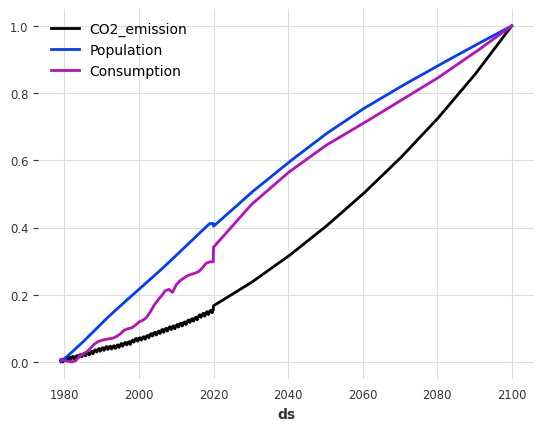

In [10]:
known_scaled[0].plot()

### Modeling

In [11]:
from darts.utils.callbacks import TFMProgressBar

In [12]:
TFT_params = {
    # hyperparameters for data preparation 
    "input_chunk_length": 120,
    "output_chunk_length": 36,

    # time series hyperparameters 
    "likelihood": QuantileRegression(quantiles=[0.25, 0.5, 0.75]),
    
    # Hyperparameters for model architecture
    "use_static_covariates": True,
    "hidden_size": 32,
    "lstm_layers": 1,
    "num_attention_heads": 4,
    'full_attention':True,

    # Hyperparameters for optimization
    "dropout": 0.5,
    "batch_size": 16,
    "n_epochs": 100,
    "random_state": 56,
    "optimizer_kwargs": {"lr": 1e-3},

    "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
}

tft_model = TFTModel(**TFT_params)

tft_model.fit(train_scaled,
            future_covariates=known_scaled,
            verbose=False)

tft_model.save("BEST_tft_ssp3.pkl")

tft_model = TFTModel.load('BEST_tft_ssp3.pkl')

In [22]:
scaled_pred = tft_model.predict(12*79, train_scaled, future_covariates=known_scaled)
pred = y_scaler.inverse_transform(scaled_pred)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


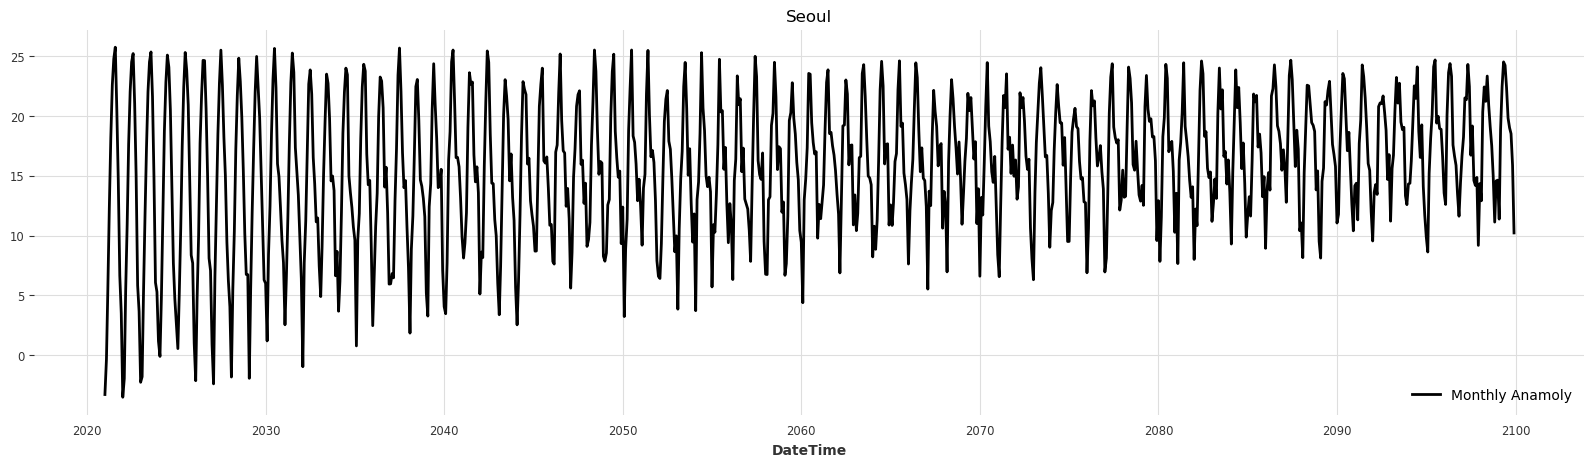

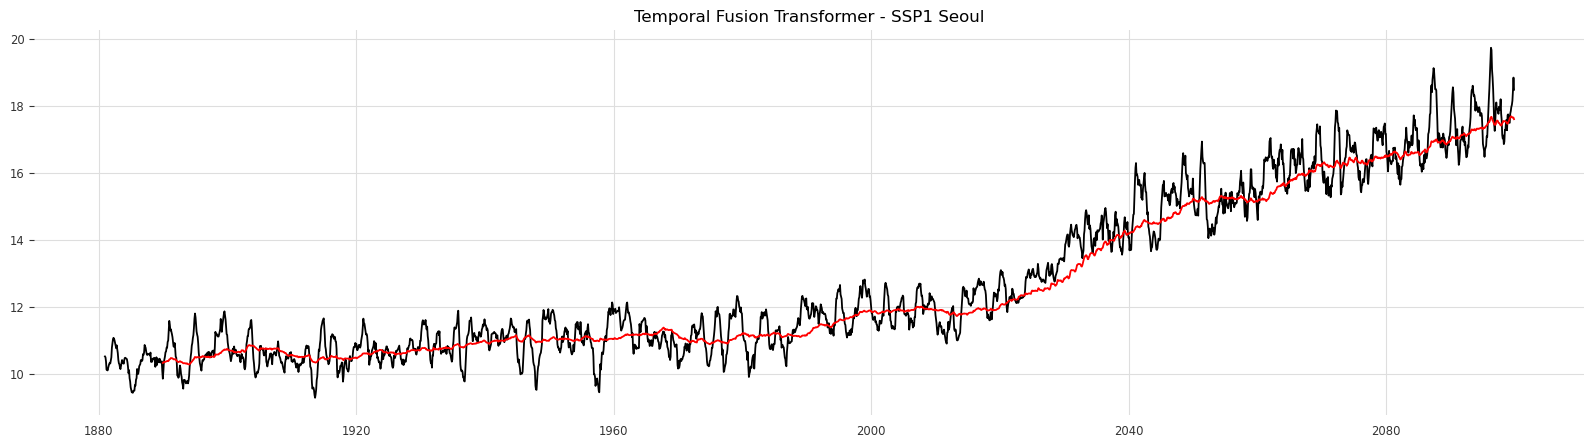

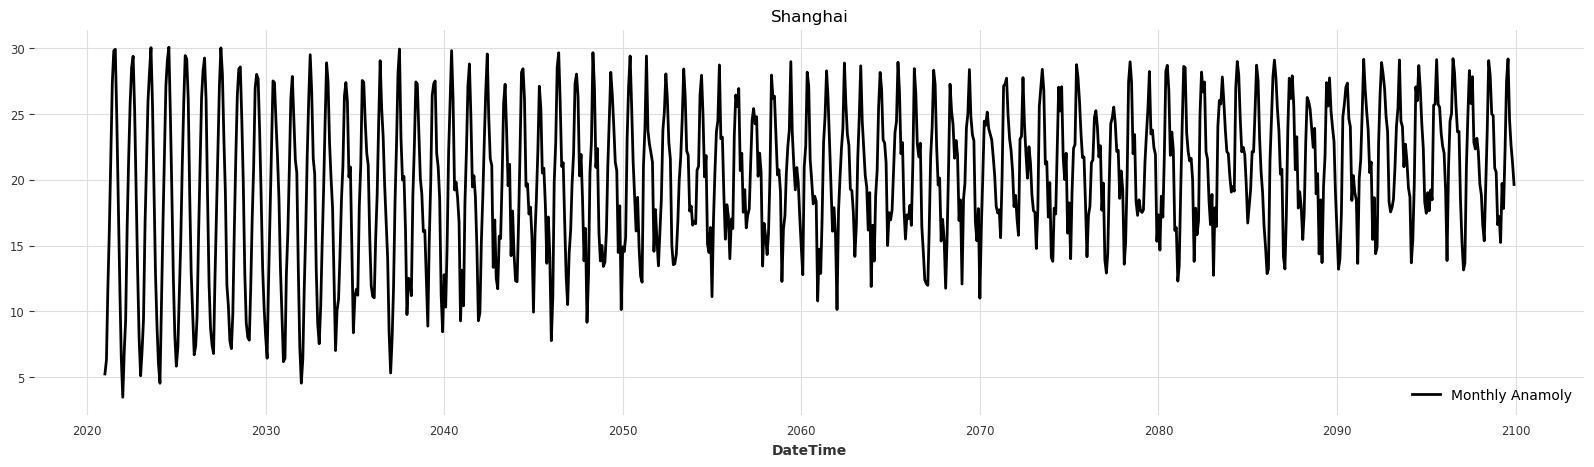

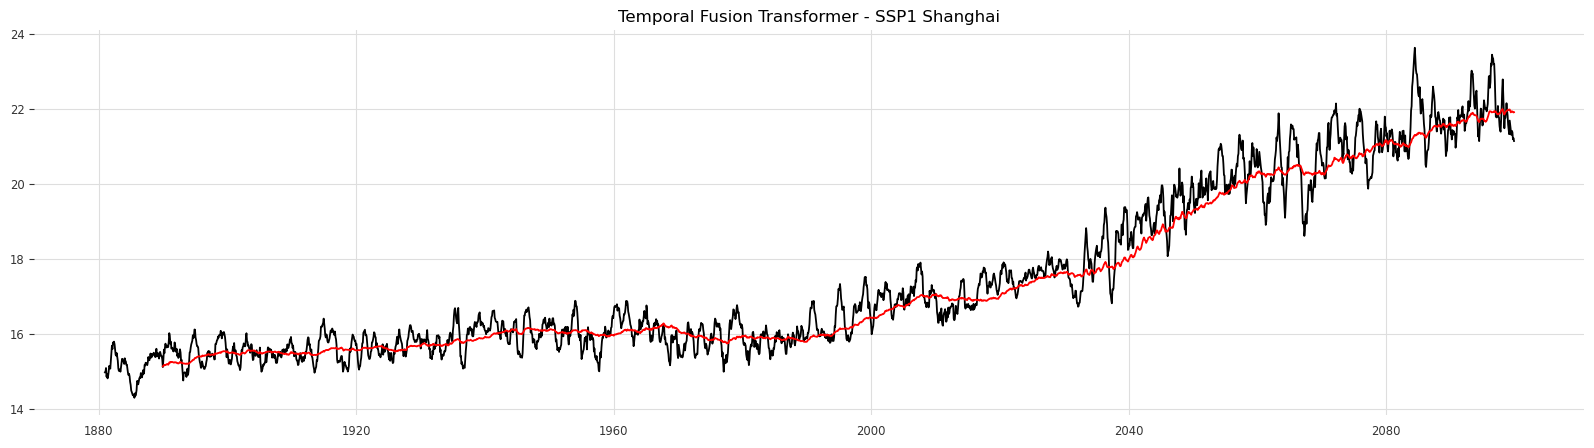

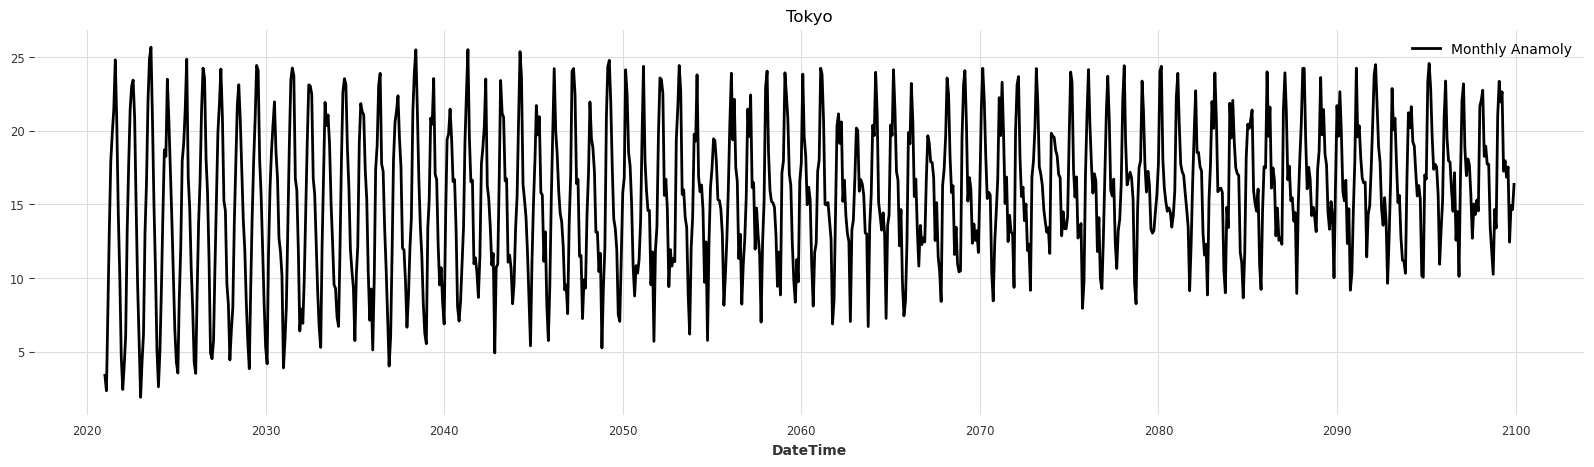

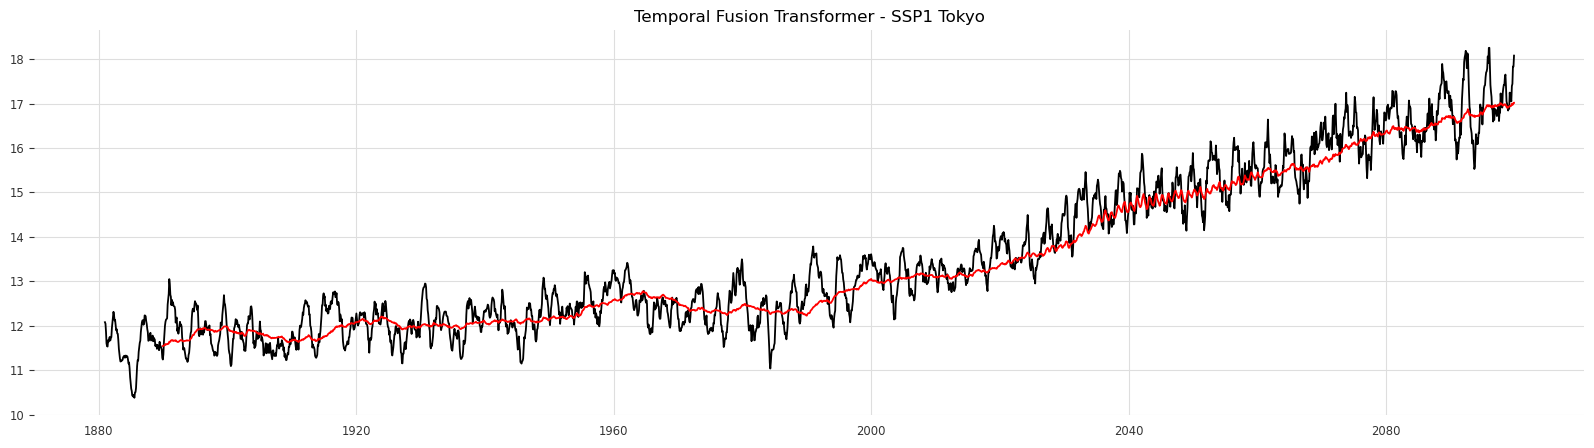

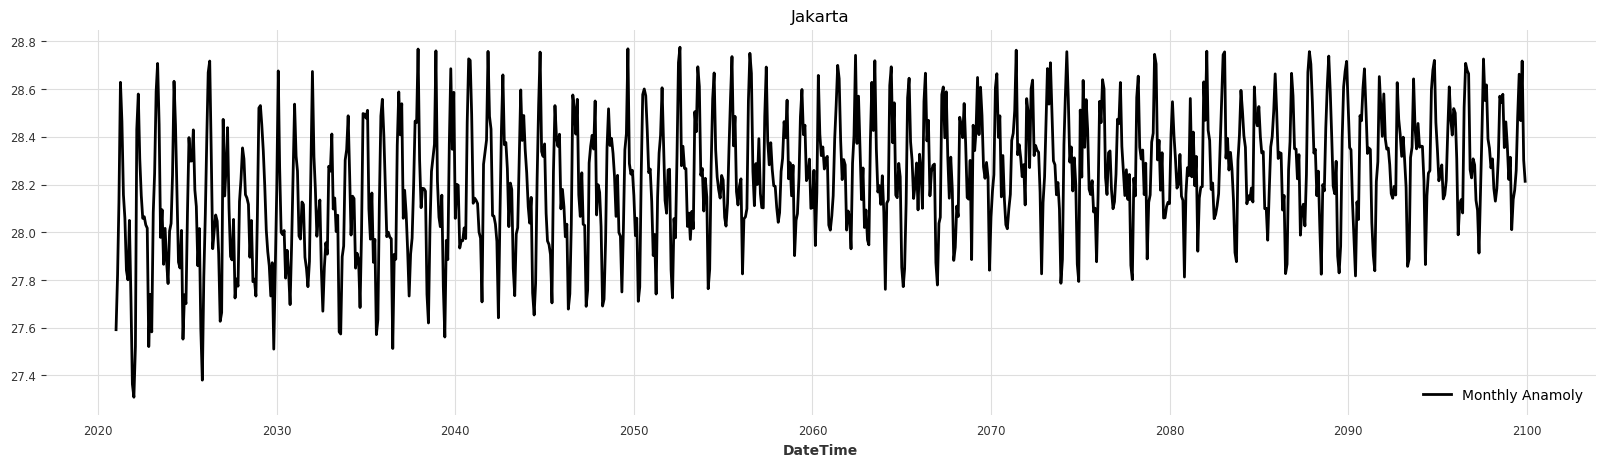

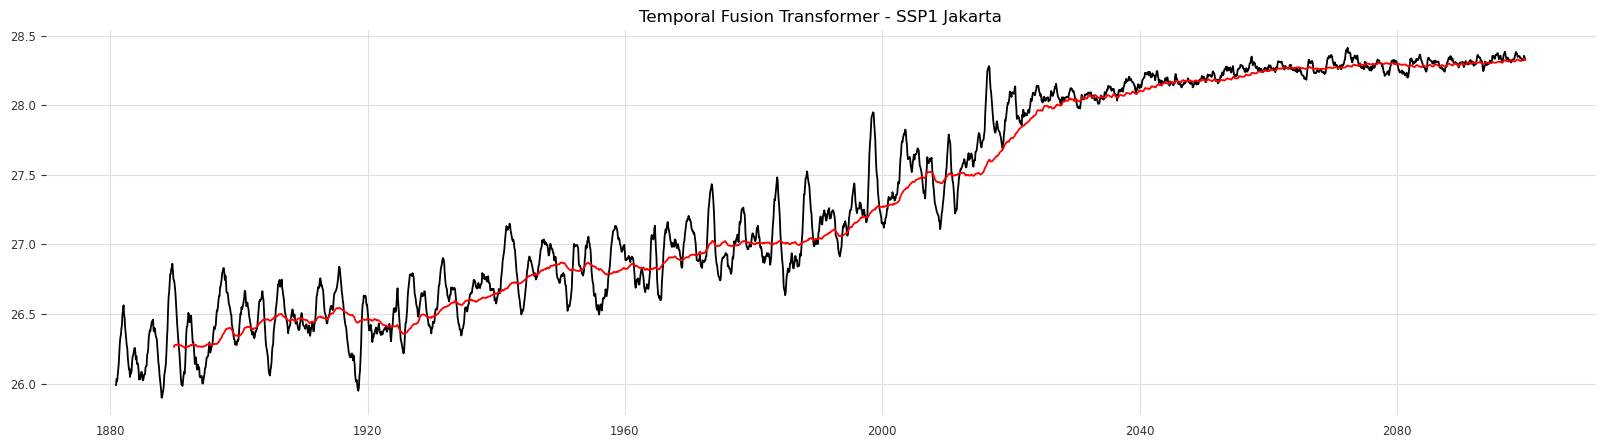

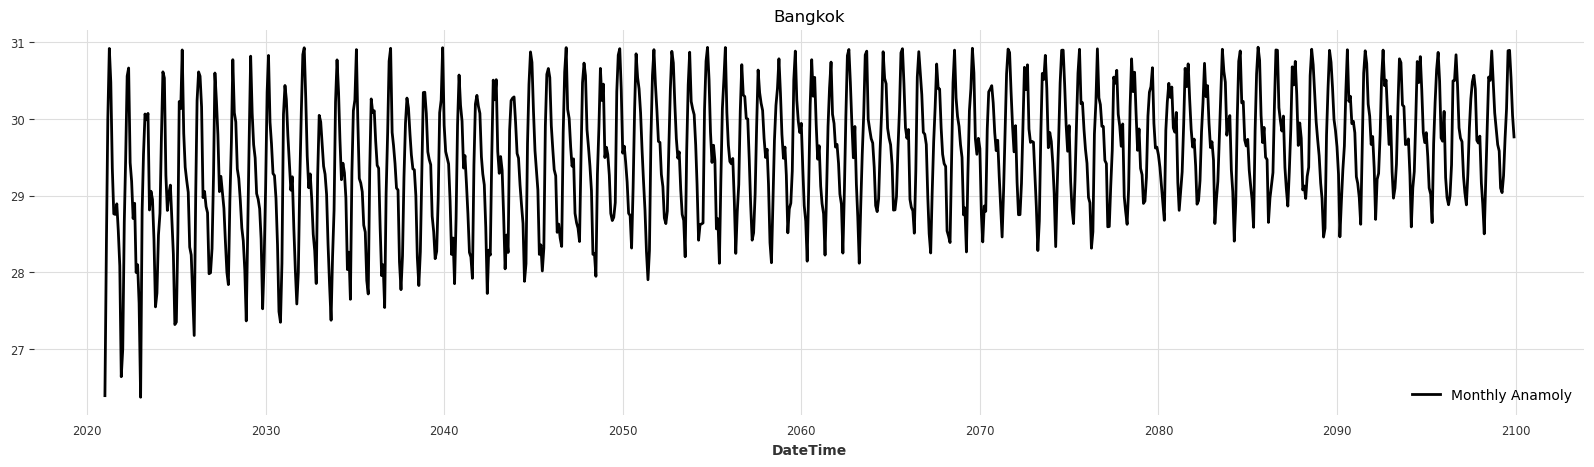

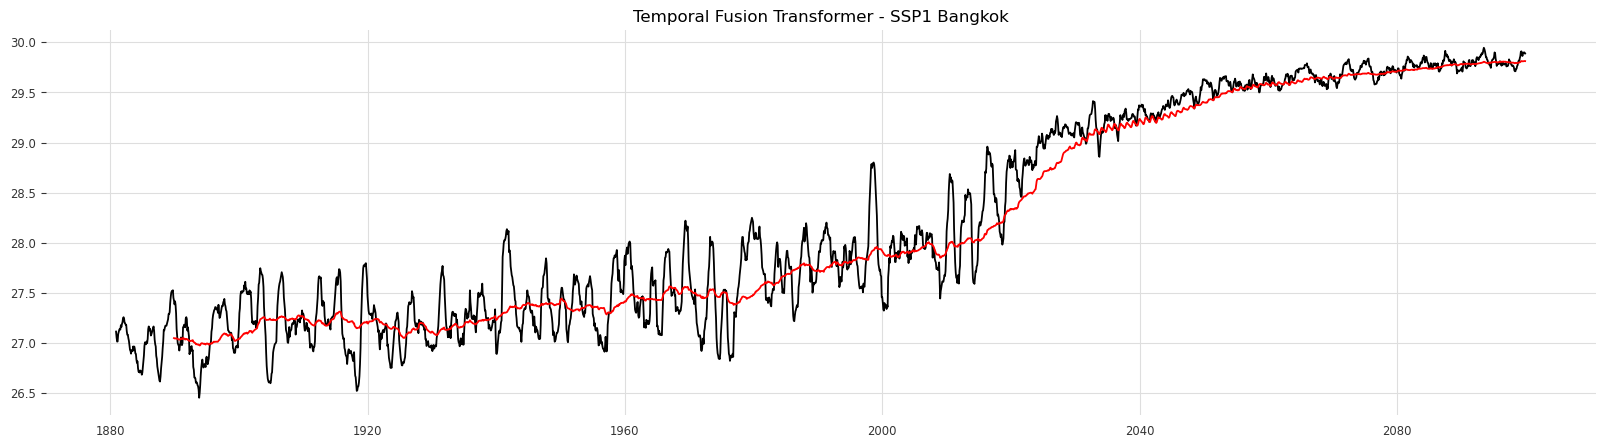

In [23]:
CITY_NAMES = ['Seoul', 'Shanghai', 'Tokyo', 'Jakarta', 'Bangkok',]

for i in range(CITY_NUMS):
    plt.figure(figsize=(20,5))
    pred[i].plot()
    plt.title(f'{CITY_NAMES[i]}')
    plt.show()

    pred[i].to_csv('a.csv')
    forecast = pd.read_csv("a.csv")
    forecast['DateTime'] = pd.to_datetime(forecast['DateTime'])
    forecast.set_index("DateTime", drop=True, inplace=True)

    oneraw = rawdata.loc[rawdata['city_num'] == i]
    oneraw['DateTime'] = pd.to_datetime(oneraw['DateTime'])
    oneraw = oneraw.loc[oneraw['DateTime'] >= '1880-01-01']
    oneraw = oneraw.loc[:,['DateTime', 'Monthly Anamoly']]
    oneraw.set_index('DateTime', inplace=True)
    
    total = pd.concat([oneraw, forecast], axis=0)
    month12_ma = total["Monthly Anamoly"].rolling(window=12).mean()
    year10_ma = total["Monthly Anamoly"].rolling(window=120).mean()
    total.to_csv(f'TFT_SSP3_forecast/tft_ssp3_{CITY_NAMES[i]}.csv')

    plt.figure(figsize=(20,5))
    plt.plot(total.index,month12_ma)
    plt.plot(total.index,year10_ma, color='red')
    plt.title(f'Temporal Fusion Transformer - SSP1 {CITY_NAMES[i]}')
    plt.show()

In [24]:
from darts.metrics import rmse, smape, mape

def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(12, 5))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=("historic " + forecast_type + " forecasts"))
    plt.title(
        f"{CITY_NAMES[i]}'s MAPE: {mape(ts_transformed.univariate_component(0), pred_series)}")
    plt.ylabel('scaled temperature')
    plt.legend()

In [25]:
pred_series = tft_model.historical_forecasts(
    train_scaled,
    future_covariates = known_scaled,
    start=pd.Timestamp('2015-01-01'),
    # forecast_horizon=120,
    stride=1,
    retrain=False,
    verbose=True,
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [41]:
pred_series[0]

<TimeSeries (DataArray) (time: 72, component: 1, sample: 1)> Size: 576B
array([[[0.10959356]],

       [[0.23350631]],

       [[0.434062  ]],

       [[0.55098374]],

       [[0.73526055]],

       [[0.84103637]],

       [[0.91464941]],

       [[0.94815853]],

       [[0.8084704 ]],

       [[0.63839644]],

...

       [[0.41301958]],

       [[0.55031099]],

       [[0.73712657]],

       [[0.88787003]],

       [[0.95197079]],

       [[0.92876788]],

       [[0.82796555]],

       [[0.62638339]],

       [[0.41844247]],

       [[0.20051985]]])
Coordinates:
  * time       (time) datetime64[ns] 576B 2015-01-01 2015-02-01 ... 2020-12-01
  * component  (component) object 8B 'Monthly Anamoly'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  city_num\ncomponent               ...
    hierarchy:          None

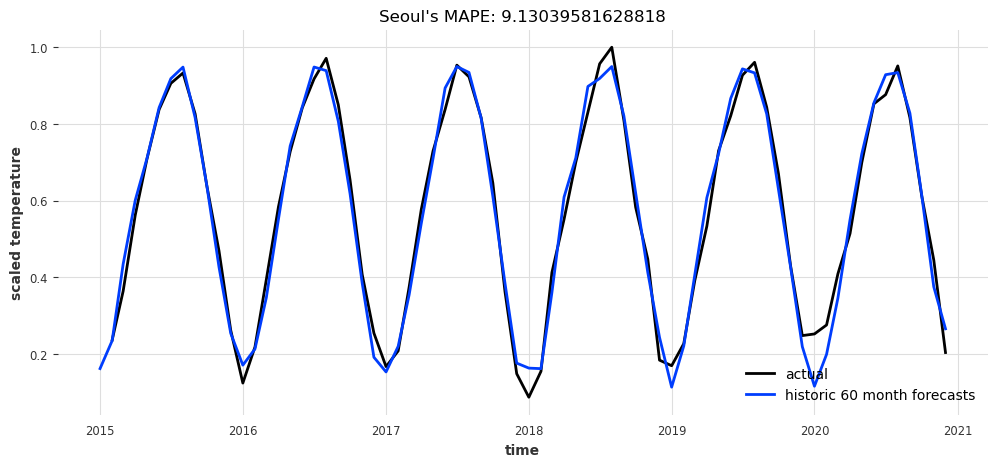

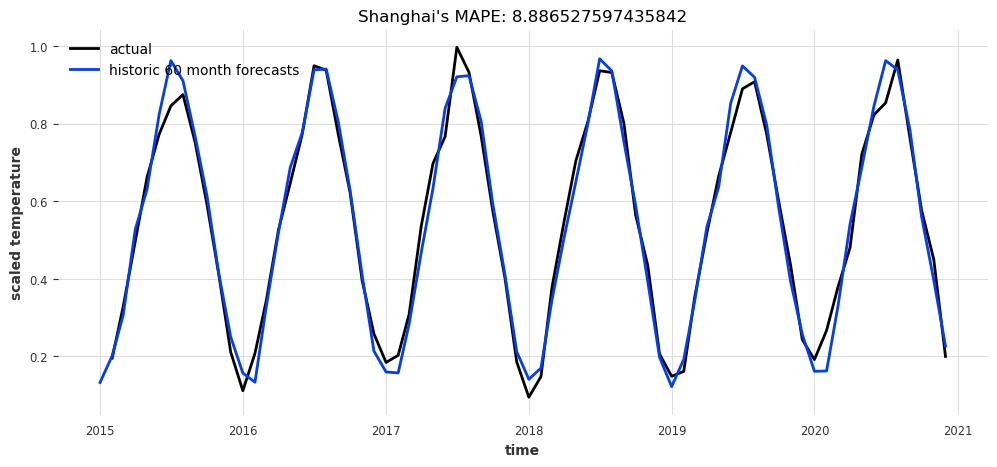

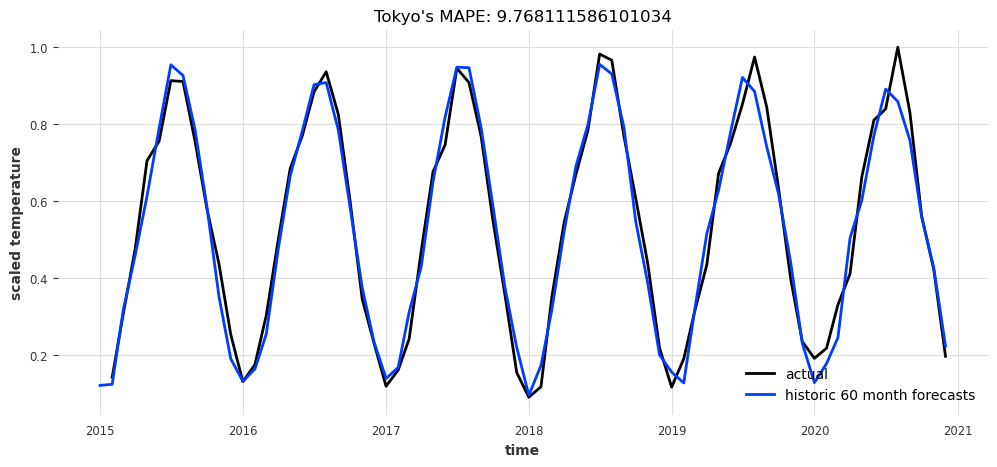

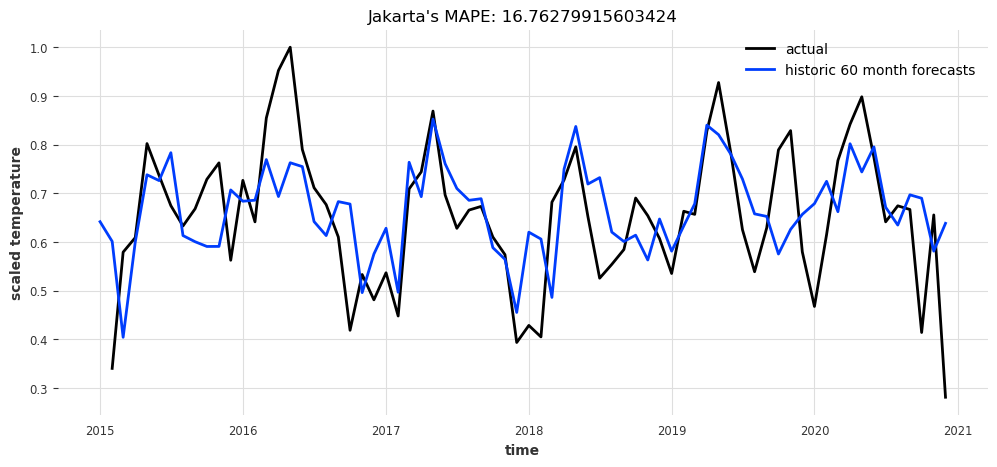

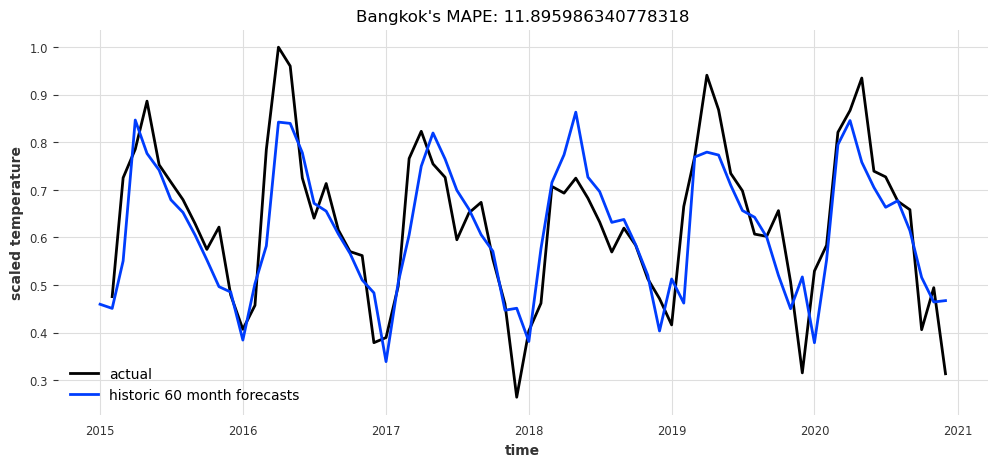

In [26]:
for i in range(CITY_NUMS):
    display_forecast(pred_series[i], train_scaled[i], "60 month", start_date=pd.Timestamp('2015-01-01'))